In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image
import numpy as np
import json
import networkx as nx

In [98]:
import import_ipynb
import data_manip_weather as weather

In [43]:
class Df:
    def __init__(self, edges_file = 'edges.json', fixes_file = 'fixes.json', weather_img = "weather.png" , weather_json = "weather.json", weather_weights = [0, 10, 20]):
        
        self.df_combined = self.create_df_from_edges_and_fixes(edges_file, fixes_file)
        self.calculate_distance()
        
        self.weather_weights = np.array(weather_weights)
        self.weather = weather.Weather(weather_img, weather_json)
        self.weather_proportion_for_edges()
        self.weather_weight_calculate()
        self.total_cost_calculate()        
                
    def create_df_from_edges_and_fixes(self, edges_file, fixes_file):
        df_edges = pd.read_json(edges_file).rename(columns={0: 'A', 1: 'B'})
        df_fixes = pd.read_json('fixes.json')
        df_fixes = df_fixes.reindex(sorted(df_fixes.columns), axis=1).astype(np.float64).T
        
        df_combined = df_edges
        df_combined["A_latitude"] = df_combined['A'].map(df_fixes["latitude"])
        df_combined["A_longitude"] = df_combined['A'].map(df_fixes["longitude"])
        df_combined["B_latitude"] = df_combined['B'].map(df_fixes["latitude"])
        df_combined["B_longitude"] = df_combined['B'].map(df_fixes["longitude"])
        return df_combined
    
    def calculate_distance(self):
        self.df_combined["Distance"] = self.df_combined.apply(lambda x: geodesic([x["A_latitude"], x["A_longitude"]] , [x["B_latitude"], x["B_longitude"]]).km, axis=1)
    
    def weather_proportion_for_edges(self):
        self.df_combined["Weather"] = self.df_combined.apply(lambda x: self.weather.weight_between_points([x["A_latitude"], x["A_longitude"]] , [x["B_latitude"], x["B_longitude"]]) , axis=1)
       
    def weather_weight_calculate(self):
        self.df_combined["Weather_weight"] = self.df_combined.apply(lambda x: (x["Weather"]/x['Weather'].sum()*x['Distance']).dot(self.weather_weights), axis=1)
    
    def total_cost_calculate(self):
        self.df_combined["Total_Cost"] = self.df_combined.apply(lambda x: x["Weather_weight"] + x['Distance'], axis=1)
        
    def weather_update(self,   weather_img = "weather.png" , weather_json = "weather.json" , weather_weights = [0, 10, 20]):
        self.weather = weather.Weather(weather_img, weather_json)
        self.weather_proportion_for_edges()
        self.weather_weights_calculate()
        self.total_cost_calculate()
        
    def weather_weights_update(self, weather_weights):
        self.weather_weights = np.array(weather_weights)
        self.weather_weight_calculate()
        self.total_cost_calculate()
        
    def get_graph(self):
         return nx.from_pandas_edgelist(self.df_combined, 'A', 'B', ['Distance', 'Weather_weight', 'Total_Cost'])

In [44]:
data = Df()

In [45]:
data.df_combined

,A,B,A_latitude,A_longitude,B_latitude,B_longitude,Distance,Weather,Weather_weight,Total_Cost
0,ABQ,ADDVL,35.043794,-106.816311,33.371758,-96.361231,980.724944,"[140, 90, 49]",6608.469155,7589.194098
1,ABQ,AHAMU,35.043794,-106.816311,34.702697,-95.864267,1001.543351,"[126, 98, 68]",8026.066581,9027.609932
2,ABQ,AKO,35.043794,-106.816311,40.155553,-103.179711,651.776859,"[99, 29, 66]",5409.075991,6060.852849
3,ABQ,ALS,35.043794,-106.816311,37.349158,-105.815536,271.177389,"[0, 24, 64]",4683.973087,4955.150476
4,ABQ,ANTHY,35.043794,-106.816311,31.310189,-100.543003,716.530016,"[117, 17, 34]",3625.300674,4341.830689
...,...,...,...,...,...,...,...,...,...,...
116103,ZUVKU,WISEP,40.876139,-124.039036,42.250111,-123.354881,162.920422,"[53, 0, 0]",0.000000,162.920422
116104,ZUVKU,WURUK,40.876139,-124.039036,44.412092,-120.921144,468.602018,"[135, 0, 0]",0.000000,468.602018
116105,ZUVKU,YAPUB,40.876139,-124.039036,38.322275,-122.949075,298.595223,"[97, 0, 0]",0.000000,298.595223
116106,ZUVKU,ZIDAX,40.876139,-124.039036,42.246989,-122.542739,196.868845,"[53, 0, 0]",0.000000,196.868845


In [46]:
G = nx.from_pandas_edgelist(data.df_combined, 'A', 'B', ['Distance', 'Weather_weight', 'Total_Cost'])

In [47]:
nx.astar_path(G, 'KSFO', 'KJFK', weight = "Di")

['KSFO',
 'KSFO:RW01L',
 'KYNNG',
 'AKUKY',
 'BAYAM',
 'AQP',
 'EFVEV',
 'JFK',
 'KJFK']

In [48]:
nx.path_weight(G, nx.astar_path(G, 'KSFO', 'KJFK', weight = "Total_Cost"), weight = "Distance")

4830.706612543995

In [49]:
nx.path_weight(G, nx.astar_path(G, 'KSFO', 'KJFK', weight = "Total_Cost"), weight = "Weather_weight")

718.2851751535438

In [50]:
nx.path_weight(G, nx.astar_path(G, 'KSFO', 'KJFK', weight = "Total_Cost"), weight = "Total_Cost")

5548.991787697539

In [51]:
df_edges = pd.read_json('edges.json')
df_edges = df_edges.rename(columns={0: 'A', 1: 'B'})

df_fixes = pd.read_json('fixes.json')
df_fixes = df_fixes.reindex(sorted(df_fixes.columns), axis=1).astype(np.float64).T

In [52]:
df_fixes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1103 entries, ABQ to ZUVKU
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   1103 non-null   float64
 1   longitude  1103 non-null   float64
dtypes: float64(2)
memory usage: 25.9+ KB


In [53]:
df_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116108 entries, 0 to 116107
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   A       116108 non-null  object
 1   B       116108 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [54]:
w = weather.Weather()

In [55]:
m = w.wmatrix()

In [56]:
m

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [57]:
df_edges[df_edges['A'] == "ADDVL"]

,A,B
384,ADDVL,AGENT
385,ADDVL,AGISM
386,ADDVL,AHAMU
387,ADDVL,ANPIY
388,ADDVL,ANY
...,...,...
451,ADDVL,WOVAS
452,ADDVL,WULBO
453,ADDVL,WYATE
454,ADDVL,ZESMO


In [58]:
df_fixes

,latitude,longitude
ABQ,35.043794,-106.816311
ABR,45.417356,-98.368719
ACO,41.107903,-81.201525
ADDVL,33.371758,-96.361231
AECIA,33.501636,-117.144678
...,...,...
ZUBUM,33.662194,-102.527178
ZUCRY,40.869361,-75.236436
ZUGTO,36.940394,-84.779761
ZULOM,32.888417,-109.676878


In [59]:
geodesic([df_fixes.loc["KSFO"][0], df_fixes.loc["KSFO"][1]] ,[ df_fixes.loc["KJFK"][0], df_fixes.loc["KJFK"][1] ]).km

4161.924389225965

In [60]:
df_combined = df_edges

In [61]:
df_combined["A_latitude"] = df_combined['A'].map(df_fixes["latitude"])
df_combined["A_longitude"] = df_combined['A'].map(df_fixes["longitude"])
df_combined["B_latitude"] = df_combined['B'].map(df_fixes["latitude"])
df_combined["B_longitude"] = df_combined['B'].map(df_fixes["longitude"])

In [62]:
df_combined

,A,B,A_latitude,A_longitude,B_latitude,B_longitude
0,ABQ,ADDVL,35.043794,-106.816311,33.371758,-96.361231
1,ABQ,AHAMU,35.043794,-106.816311,34.702697,-95.864267
2,ABQ,AKO,35.043794,-106.816311,40.155553,-103.179711
3,ABQ,ALS,35.043794,-106.816311,37.349158,-105.815536
4,ABQ,ANTHY,35.043794,-106.816311,31.310189,-100.543003
...,...,...,...,...,...,...
116103,ZUVKU,WISEP,40.876139,-124.039036,42.250111,-123.354881
116104,ZUVKU,WURUK,40.876139,-124.039036,44.412092,-120.921144
116105,ZUVKU,YAPUB,40.876139,-124.039036,38.322275,-122.949075
116106,ZUVKU,ZIDAX,40.876139,-124.039036,42.246989,-122.542739


In [63]:
df_combined["distance"] = df_combined.apply(lambda x: geodesic([x["A_latitude"], x["A_longitude"]] , [x["B_latitude"], x["B_longitude"]]).km, axis=1)

In [64]:
df_combined

,A,B,A_latitude,A_longitude,B_latitude,B_longitude,distance
0,ABQ,ADDVL,35.043794,-106.816311,33.371758,-96.361231,980.724944
1,ABQ,AHAMU,35.043794,-106.816311,34.702697,-95.864267,1001.543351
2,ABQ,AKO,35.043794,-106.816311,40.155553,-103.179711,651.776859
3,ABQ,ALS,35.043794,-106.816311,37.349158,-105.815536,271.177389
4,ABQ,ANTHY,35.043794,-106.816311,31.310189,-100.543003,716.530016
...,...,...,...,...,...,...,...
116103,ZUVKU,WISEP,40.876139,-124.039036,42.250111,-123.354881,162.920422
116104,ZUVKU,WURUK,40.876139,-124.039036,44.412092,-120.921144,468.602018
116105,ZUVKU,YAPUB,40.876139,-124.039036,38.322275,-122.949075,298.595223
116106,ZUVKU,ZIDAX,40.876139,-124.039036,42.246989,-122.542739,196.868845


(array([ 843., 1896., 3003., 4035., 4753., 5448., 6082., 6403., 6947.,
        7113., 7354., 7349., 7352., 7445., 7370., 7108., 6909., 6744.,
        6246., 5708.]),
 array([9.33145782e-03, 5.01361355e+01, 1.00262940e+02, 1.50389744e+02,
        2.00516548e+02, 2.50643352e+02, 3.00770156e+02, 3.50896960e+02,
        4.01023764e+02, 4.51150568e+02, 5.01277372e+02, 5.51404176e+02,
        6.01530980e+02, 6.51657784e+02, 7.01784589e+02, 7.51911393e+02,
        8.02038197e+02, 8.52165001e+02, 9.02291805e+02, 9.52418609e+02,
        1.00254541e+03]),
 <BarContainer object of 20 artists>)

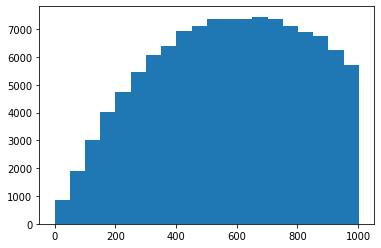

In [65]:
plt.hist(df_combined["distance"], 20)

In [66]:
G = nx.Graph()
G.add_edge(1, 2)  # default edge data=1
G.add_edge(2, 3, weight=0.9)

In [67]:
G

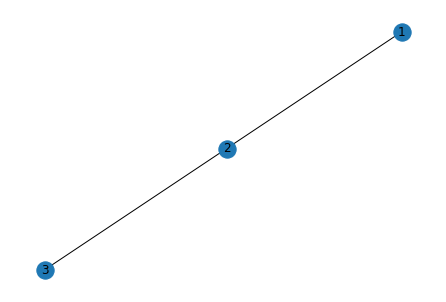

In [68]:
nx.draw(G, with_labels = True)

In [69]:
elist = [('a', 'b', 1.0), ('b', 'c', 3.0), ('a', 'c', 1.0), ('c', 'd', 7.3)]
G = nx.Graph()

G.add_weighted_edges_from(elist)

In [70]:
G

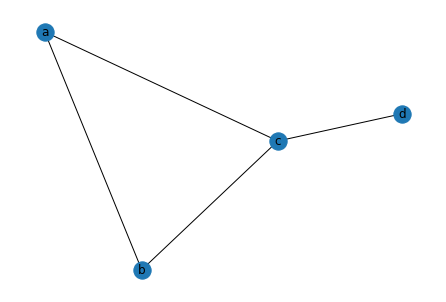

In [71]:
nx.draw(G, with_labels = True)

In [72]:
nx.astar_path(G, 'a', 'd')

['a', 'c', 'd']

In [73]:
G = nx.from_pandas_edgelist(df_combined, 'A', 'B', ['distance'])

In [74]:
G

In [75]:
pos=nx.spring_layout(G)

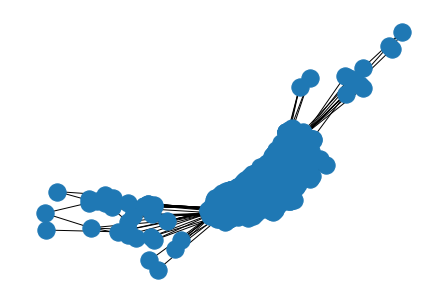

In [76]:
nx.draw(G, pos)

In [77]:
nx.astar_path(G, 'ABQ', 'ADDVL')

['ABQ', 'ADDVL']

In [78]:
nx.astar_path(G, 'ADDVL', 'ABQ')

['ADDVL', 'ABQ']

In [79]:
nx.astar_path(G, 'KSFO', 'KJFK')

['KSFO',
 'KSFO:RW01L',
 'KYNNG',
 'AKUKY',
 'BAYAM',
 'AQP',
 'EFVEV',
 'JFK',
 'KJFK']

In [80]:
nx.path_weight(G, nx.astar_path(G, 'KSFO', 'KJFK'), weight = "distance")

4632.934500858076

In [81]:
df_combined.describe()

,A_latitude,A_longitude,B_latitude,B_longitude,distance
count,116108.000000,116108.000000,116108.000000,116108.000000,116108.000000
mean,40.069040,-103.567810,40.643914,-99.029553,570.217115
std,4.179329,13.937375,3.764118,13.503534,249.445581
min,31.293364,-127.000000,31.293364,-127.000000,0.009331
25%,37.404853,-114.081778,38.340028,-109.356272,374.558769
50%,40.000000,-106.000000,40.848719,-101.389769,579.818206
75%,43.000000,-94.737061,43.000000,-89.763722,777.456601
max,48.869417,-70.402136,48.869417,-70.402136,1002.545413


In [82]:
nx.dijkstra_path(G, 'KSFO', 'ZORUN')

['KSFO', 'KSFO:RW01L', 'KYNNG', 'ZORUN']

In [83]:
from geographiclib.geodesic import Geodesic
import math

In [84]:
geod = Geodesic.WGS84

In [91]:
g = geod.Inverse(55.78   ,  -135.0, 55.7535625 , -134.94726562, Geodesic.DISTANCE)
g['s12']/1000

In [94]:
g['s12']/1000

4.429493886863273

In [87]:
g = geod.Inverse(21.992875  ,   -67.60546875, 21.9664375 , -67.55273438)

In [88]:
g

{'lat1': 21.992875,
 'lon1': -67.60546875,
 'lat2': 21.9664375,
 'lon2': -67.55273438,
 'a12': 0.05570490410746527,
 's12': 6183.150516415978,
 'azi1': 118.2487299642972,
 'azi2': 118.26846724675562}

In [89]:
l = geod.InverseLine(35.043794, -106.816311, 33.371758, -96.361231)
ds = 60e3; n = int(math.ceil(l.s13 / ds))
for i in range(n + 1):
    if i == 0:
        print("distance latitude longitude azimuth")
    s = min(ds * i, l.s13)
    g = l.Position(s, Geodesic.STANDARD | Geodesic.LONG_UNROLL)
    print("{:.0f} {:.5f} {:.5f} {:.5f}".format(
    g['s12'], g['lat2'], g['lon2'], g['azi2']))

distance latitude longitude azimuth
0 35.04379 -106.81631 97.92091
60000 34.96752 -106.16558 98.29421
120000 34.88776 -105.51607 98.66608
180000 34.80454 -104.86785 99.03646
240000 34.71787 -104.22096 99.40530
300000 34.62778 -103.57544 99.77253
360000 34.53427 -102.93134 100.13810
420000 34.43737 -102.28871 100.50197
480000 34.33711 -101.64758 100.86407
540000 34.23349 -101.00800 101.22435
600000 34.12654 -100.37002 101.58277
660000 34.01628 -99.73366 101.93928
720000 33.90274 -99.09897 102.29382
780000 33.78594 -98.46599 102.64636
840000 33.66589 -97.83474 102.99684
900000 33.54263 -97.20527 103.34523
960000 33.41618 -96.57761 103.69147
980725 33.37176 -96.36123 103.81056


In [90]:
l = geod.InverseLine(35.043794, -106.816311, 33.371758, -96.361231)
ds = 60e3; n = int(math.ceil(l.s13 / ds))
for i in range(n + 1):
    if i == 0:
        print("distance latitude longitude azimuth")
    s = min(ds * i, l.s13)
    g = l.Position(s, Geodesic.LATITUDE | Geodesic.LONGITUDE )
    print("{:.0f} {:.5f} {:.5f}".format(
    g['s12'], g['lat2'], g['lon2']))

distance latitude longitude azimuth
0 35.04379 -106.81631
60000 34.96752 -106.16558
120000 34.88776 -105.51607
180000 34.80454 -104.86785
240000 34.71787 -104.22096
300000 34.62778 -103.57544
360000 34.53427 -102.93134
420000 34.43737 -102.28871
480000 34.33711 -101.64758
540000 34.23349 -101.00800
600000 34.12654 -100.37002
660000 34.01628 -99.73366
720000 33.90274 -99.09897
780000 33.78594 -98.46599
840000 33.66589 -97.83474
900000 33.54263 -97.20527
960000 33.41618 -96.57761
980725 33.37176 -96.36123
